In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib import cm

from skimage import io
from skimage.color import rgb2gray

from mpmath import mp, mpf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

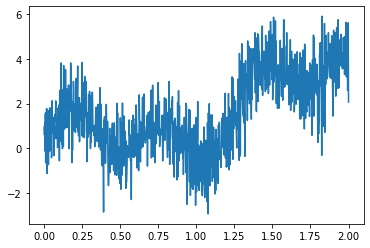

In [86]:
t = np.linspace(0, 2, 1000)
f = t**2 + np.sin(5*t) + np.sin(10*t) + np.random.normal(size=1000)

def gen_poly(c, t):
    f = np.zeros(len(t))
    for i in range(len(c)):
        f += c[i] * t**(i+1)
    return f

plt.plot(t, f)

In [89]:
model = Pipeline([('poly', PolynomialFeatures(degree=20)),
...               ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(t[:, np.newaxis], f)
coeffs = model.named_steps['linear'].coef_

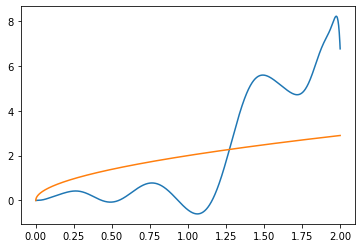

In [115]:
F1 = gen_poly(coeffs, t)
F2 = t**0.63 + t**0.43

plt.plot(t, F1)
plt.plot(t, F2)

# Fractal Geometry

## What is A Fractal, Really?

Mendelbrot, the father of fractal geometry, was notoriously. The mathematician Kenneth Falconer has en

1. $F$ has a fine structure, i.e. detail on arbitrarily small scales.
2. $F$ is too irregular to be described in traditional geometrical language, both locally and globally.
3. Often, $F$ has some form of self-similarity, perhaps approximate or statistical.
4. Usually, the ‘fractal dimension’ of $F$ (defined in some way) is greater than its topological dimension.
5. In most cases of interest $F$ is defined in a very simple way, perhaps recursively.

Because we are working in an applied rather than a purely mathematical setting, Falconer's last point is simply not true. Most often, there will be no easy way to define mathematically the objects and processes we find ourselves interested in, and we will have to settle for characterizing them in some way.

## Fractal Dimension

### Generating Self-Similar Fractals with L-Systems

In [528]:
def lsystem(start, rules):
    out = ''
    for c in start:
        s = rules[c]
        out += s
        
    return out


def word2points(word, angle):
    phi = np.deg2rad(angle)
    rot = 0.
    p = np.zeros((2,1))
    R = np.eye(2)
    v = np.array([[1.], [0.]])
    points = [p]
    for symbol in word:
        if symbol == '-':
            rot -= phi
        elif symbol == '+':
            rot += phi
        elif symbol in ['F','G']:
            c = np.cos(rot)
            s = np.sin(rot)
            R[0,:] = [ c, s]
            R[1,:] = [-s, c]
            p = np.dot(R, v) + p
            points.append(p)
    return np.hstack(points)


def Plot2Matrix(points, figsz=(20, 8)):
    # Plot the points
    plt.clf()
    fig = Figure(figsize=(20, 8), dpi=200)
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.scatter(points[0,:], points[1,:], s=0.1, c='k')
    ax.axis('off')
    # Draw the canvas, cache the renderer
    canvas.draw()
    # Print the image as text in buffer
    s, (width, height) = canvas.print_to_buffer()
    # Convert the text to an array
    return np.frombuffer(s, np.uint8).reshape((height, width, 4))[:, :, 0] < 255

### Recursively Generating the Koch Curve

In [560]:
AXIOM_K = 'F'
RULES_K = { 'F' : 'F+F--F+F',
          '+' : '+',
          '-' : '-' }
ITERATIONS = 10

s_K = AXIOM_K
for i in range(ITERATIONS):
    s_K = lsystem(s_K, RULES_K)

In [561]:
koch = word2points(s_K, 60)
koch[1,:] = -1*koch[1,:]

In [562]:
koch_curve = Plot2Matrix(koch, (20, 5.7735))

<Figure size 432x288 with 0 Axes>

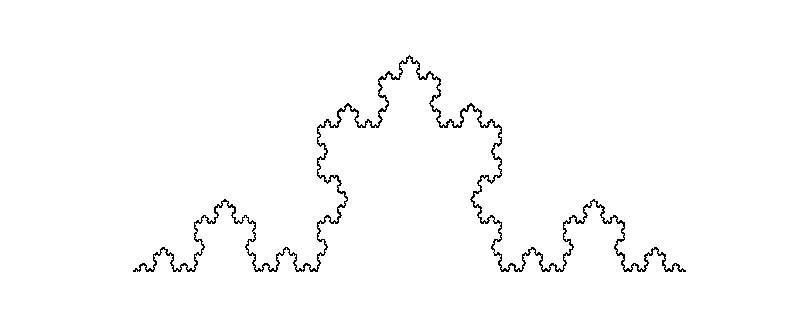

In [563]:
_ = plt.figure(figsize=(20,5.7735))
_ = plt.imshow(koch_curve, cmap = plt.cm.binary)
_ = plt.axis('off')

### Recursively Generating the Sierpinski Gasket

In [564]:
AXIOM_S = 'F-G-G'
RULES_S = { 'F' : 'F-G+F+G-F',
          'G' : 'GG',
          '+' : '+',
          '-' : '-' }
ITERATIONS = 10

s_S = AXIOM_S
for i in range(ITERATIONS):
    s_S = lsystem(s_S, RULES_S)

In [565]:
sierp = word2points(s_S, 120)

In [566]:
sierp_gasket = Plot2Matrix(sierp, (20,20))

<Figure size 432x288 with 0 Axes>

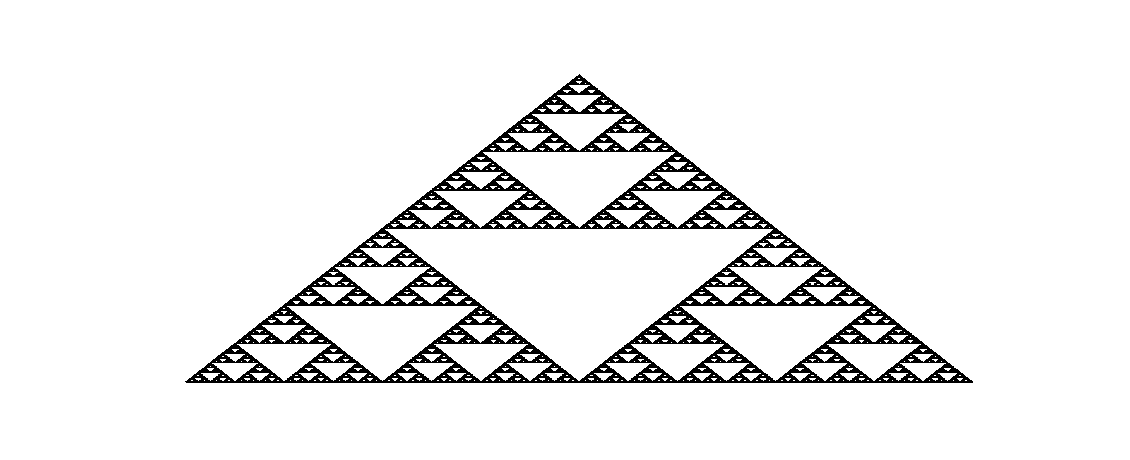

In [567]:
_ = plt.figure(figsize=(20,20))
_ = plt.imshow(sierp_gasket, cmap = plt.cm.binary)
_ = plt.axis('off')

### Trying to Measure the Length and Area of the Koch Curve: The Need for a New Concept of Dimension

### The Haussdorf Dimension

<div>
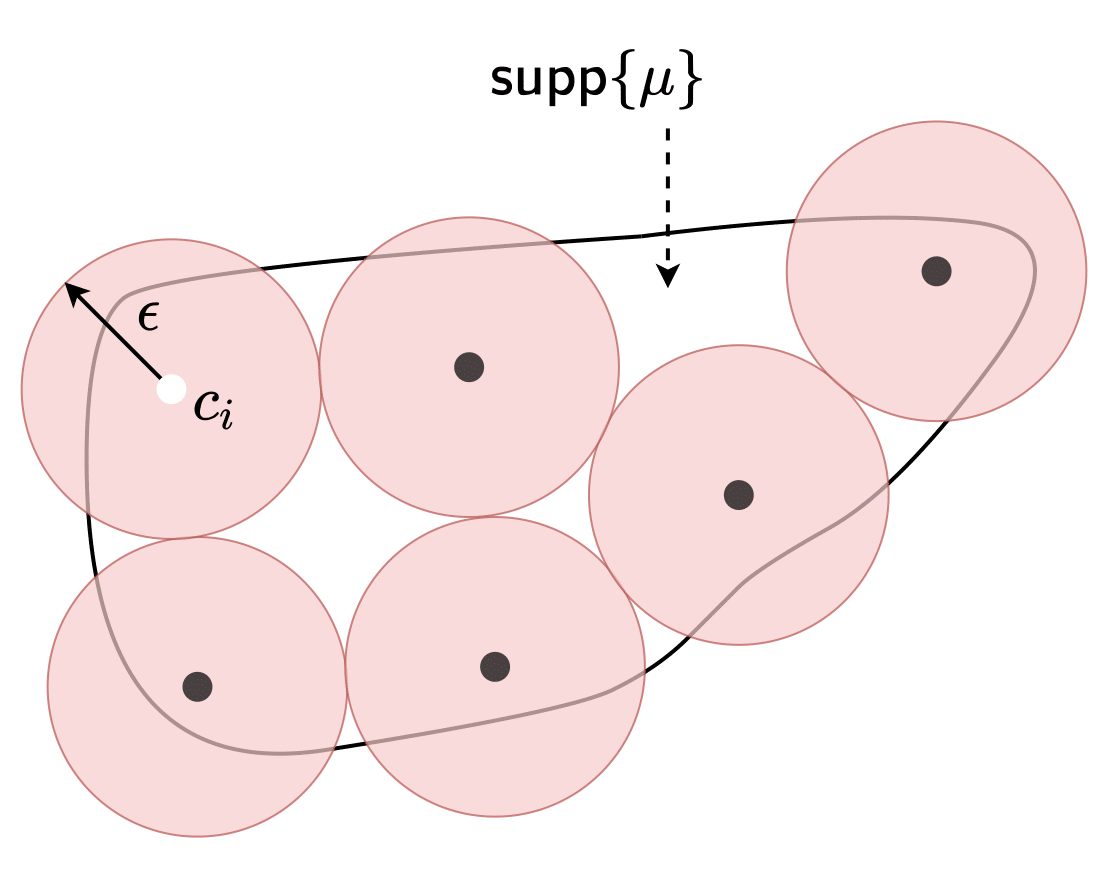
</div>

### The Box-Counting or Minkowski-Bouligand Dimension

In [589]:
def Next_Power_Of_Two(number):
    # Returns next power of two following 'number'
    return np.ceil(np.log2(number))


def Pad_to_Square(F):
    # Pad the matrix F to be square w/
    # Length = nearest power of 2
    r, c = F.shape
    max_dim = max(r,c)
    nextPower = Next_Power_Of_Two(max_dim)
    r_deficit = int(2**nextPower - r)
    c_deficit = int(2**nextPower - c)
    F_pad = np.pad(F, ((0, r_deficit),(0, c_deficit)), 'constant')
    return F_pad


def Least_Squares(data):
    xs = np.log(data[:,0])
    ys = np.log(data[:,1])
    A = np.vstack([xs, np.ones(len(xs))]).T
    m,b = np.linalg.lstsq(A, ys, rcond=None)[0]
    lin_reg = m*xs + b
    return m, xs, ys, lin_reg


def Box_Count_Dim(F, plot_regression=True, verbose=True):
    # Pad the matrix
    F_pad = Pad_to_Square(F)
    # Compute box counting dimension by halving box size
    R, C = F_pad.shape
    # Number of times we can cut box size in half
    n = int(np.log(C)/np.log(2))
    # List to hold counts of non-empty boxes
    cnts = []
    for lev in range(n):
        block_size = 2**lev
        cnt = 0
        for j in range(int(size/block_size)):
            for i in range(int(size/block_size)):
                cnt = cnt + F_pad[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size].any()
        cnts.append(cnt)
    data = np.array([(2**(n-(k+1)),cnts[k]) for k in range(n)])
    # Log-Log linear regression to get dimension
    m, x, y, L = Least_Squares(data)
    if verbose:
        print(f"Box Counting Dimension: {m}")
    if plot_regression:
        plt.clf()
        plt.figure(figsize=(8,8))
        plt.scatter(x, y, c='C1')
        plt.plot(x, L, c='b')
        plt.xlabel(r'log($\varepsilon$)', size=20)
        plt.ylabel(r'log($N(\varepsilon)$)', size=20)
    return data, m

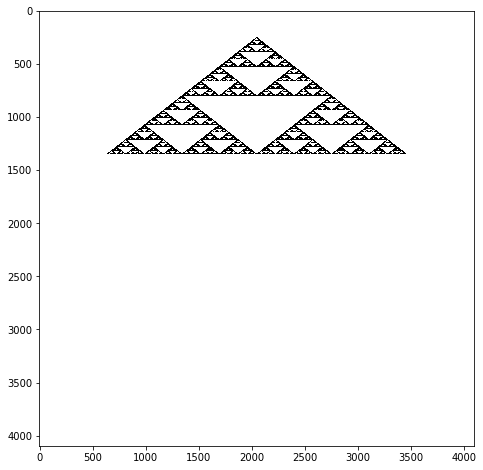

In [448]:
sierp_pad = Pad_to_Square(sierp_gasket)
plt.figure(figsize=(12,8))
_ = plt.imshow(F_pad, cmap = plt.cm.binary)

Box Counting Dimension: 1.6044777883152672


<Figure size 432x288 with 0 Axes>

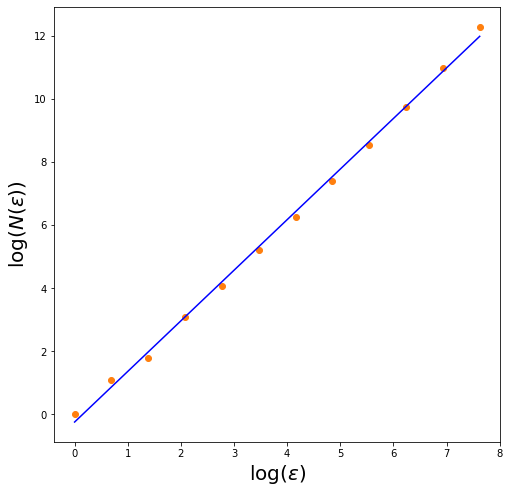

In [542]:
data_sierpinski, d_sierpinski = Box_Count_Dim(sierp_gasket)

Box Counting Dimension: 1.3801708934084582


<Figure size 432x288 with 0 Axes>

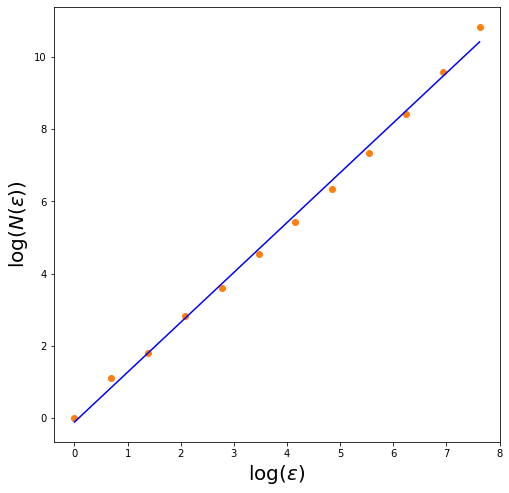

In [543]:
data_koch, d_koch = Box_Count_Dim(koch_curve)

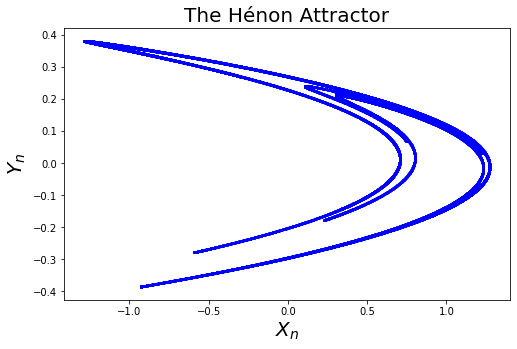

In [388]:
def henon_map(xn, yn, a, b):
    """
    Two-dimensional dissipative map.
    :param xn: First evolution point.
    :param yn: Second evolution point.
    :param a: First system parameter.
    :param b: Second system parameter.
    :return: Next iteration.
    """
    return yn + 1 - (a * xn**2), b*xn


def plot_attractor(x, y):
    plt.figure(figsize=(8,5))
    plt.scatter(x, y, c="blue", s=1)
    plt.xlabel(r"$X_n$", size=20)
    plt.ylabel(r"$Y_n$", size=20)
    plt.title("The H\xe9non Attractor", size=20)
    plt.show()


# Number of iterations
iterations = 100000

# Store iterations of xn and yn        
xt, yt = [], []

# Initial conditions and parameters
x = -.75 
y = .32 
a = 1.4 
b = 0.3

# Set decimal precision of all parameters except iterations
mp.dps = 10 

for _ in range(iterations + 1):
    xn, yn = henon_map(x, y, a, b)
    xt.append(x)
    yt.append(y)
    # Forward evolutions
    x, y = xn, yn 
    
# Plot Henon map
plot_attractor(xt, yt)

In [547]:
attractor_pts = np.array([xt, yt])
henon = Plot2Matrix(attractor_pts)

<Figure size 432x288 with 0 Axes>

Box Counting Dimension: 1.3079107319115324


<Figure size 432x288 with 0 Axes>

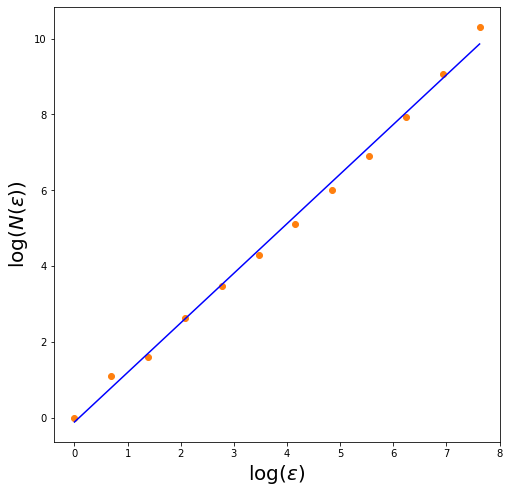

In [548]:
data_henon, d_henon = Box_Count_Dim(henon)

# Multifractal Analysis

As we have already indicated, fractal formalisms offer us a way to characterize objects and processes that exhibit irregularities or "roughness". Most objects and processes in nature, however, will not display the nice self-similarity seen in many mathematical fractals such as the Koch snowflake. In other words, we can say that most objects and processes do not exhibit the same scale-invariance across all scales or at every point in space/time (as is required by the definition of self-similarity). More technically, the scaling relationship

$$ f(\lambda x) = \lambda^H f(x) $$

may have a range of different exponents $H$ at different scales $\lambda$ and/or different points $x$. Such objects and processes are called _multifractal_.

Fractal analysis is concerned with two related but distinct problems:

1. Characterizing how objects and processes scale
2. Characterizing objects and processes that exhibit irregularities or "roughness"

Though we shall see that especially in the case of multifractals these two problems are intertwined, they should be considered distinct approaches to fractal analysis. This distinction and the relation between the two approaches will be made more clear below.

### Temporal Intermittency and Spatial Inhomogeneities

Although the notion of multifractality was developed primarily for characterizing measures (probability distributions) and functions, we can gain some intution for what multifractality is all about by considering again sets of points in space.

https://sagejenson.com/

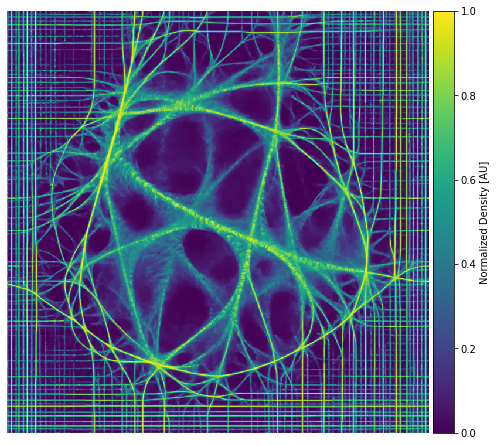

In [151]:
img = io.imread('phys.gif')
img_grey = rgb2gray(img)

_ = plt.figure(figsize=(8,8))
_ = plt.axis('off')
ax = plt.gca()
im = ax.imshow(img_grey)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_ = plt.colorbar(im, cax=cax, label='Normalized Density [AU]')

Box Counting Dimension: 1.9250624324289012
Box Counting Dimension: 1.8934562281233718
Box Counting Dimension: 1.8662546013720718
Box Counting Dimension: 1.849233907335836
Box Counting Dimension: 1.8327227035520155
Box Counting Dimension: 1.8195420781661469
Box Counting Dimension: 1.8057407664232084
Box Counting Dimension: 1.794016993193369
Box Counting Dimension: 1.7798630899455992
Box Counting Dimension: 1.7649195979662384
Box Counting Dimension: 1.750994072773975
Box Counting Dimension: 1.7375119071396992
Box Counting Dimension: 1.7219503091552792
Box Counting Dimension: 1.7047466014702066
Box Counting Dimension: 1.6879612449263848
Box Counting Dimension: 1.6741355025854112
Box Counting Dimension: 1.6546274602855189
Box Counting Dimension: 1.6325180944252258
Box Counting Dimension: 1.6080514703293904
Box Counting Dimension: 1.5848993607260464
Box Counting Dimension: 1.5598059264637303
Box Counting Dimension: 1.525926835648282
Box Counting Dimension: 1.487206409760696
Box Counting Dim

/home/noahguzman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


Box Counting Dimension: nan


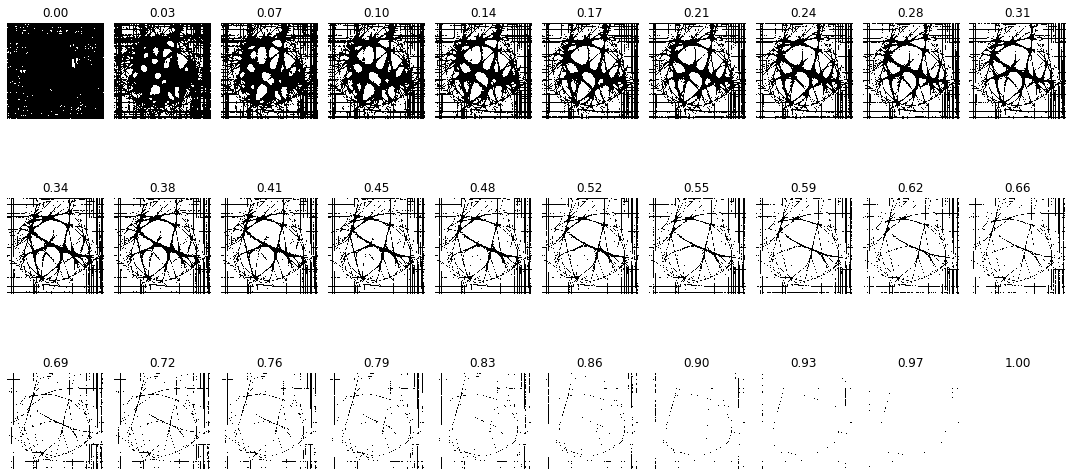

In [402]:
fig = plt.figure(figsize=(15,8))
thresh = np.linspace(0,1,30)
dims = []
with np.errstate(divide='ignore', invalid='ignore'):
    for i in range(30):
        ax = fig.add_subplot(3,10,i+1)
        ax.imshow(img_grey > thresh[i], cmap='Greys')
        ax.set_title(f'{thresh[i]:.2f}')
        ax.set_axis_off()
        data_t, d_t = Box_Count_Dim(img_grey > thresh[i], plot_regression=False)
        dims.append(d_t)
    fig.tight_layout()

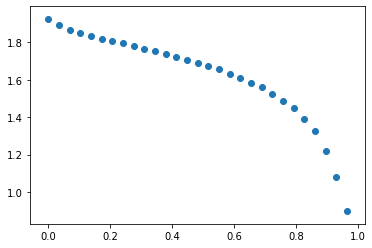

In [404]:
plt.scatter(thresh, dims)

So far, we have been concerned with analyzing sets of points in space or time, such as the locations of organisms in an ecosystem. However, in most applied settings, we will be concerned not with the sets of points but with _measures_ (for our purpose, probability distributions) associated with those points, such as the spatial density of the organisms (i.e. the probability of finding an organism in a particular location).

It may at first seem strange to think about the probability distribution associated with a time series, but if we take a dynamical systems or statistical mechanics perspective, it actually becomes quite natural. Consider that all time series $\{X_t\}_{t=0}^T$ represent the evolution of some observable through a state space, allowing us to conceive of each relization $X_t = x$ as a point in this state space.

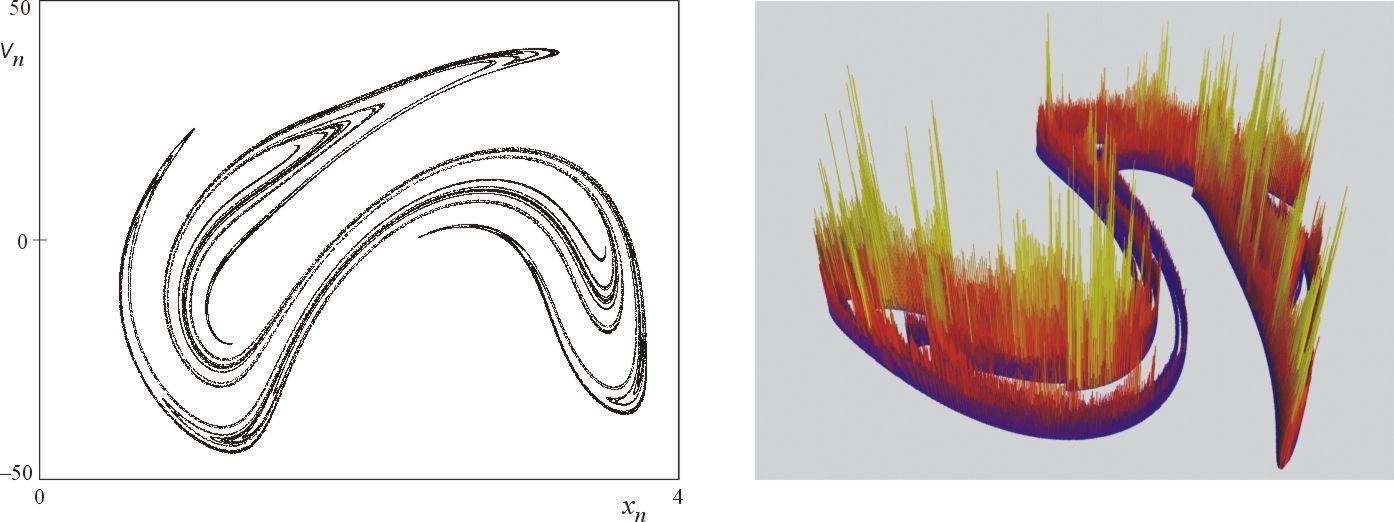

## Characterizing Inhomogeneity Across Scales: The Mass Exponent $\tau_\mu(q)$ and the Generalized or Rényi Dimension $D_\mu(q)$

We can characterize the inhomogeneity of a measure (i.e. how _non-uniform_ it is) by characterizing the scaling behavior of the measure in different regions of its support. If the measure is relatively homogenous, then we would expect it to scale in the same way across its entire support. However, if the measure is inhomogenous (i.e. if it looks "spiky" as in the plot above), then we would expect different regions of the measure to scale differently. More specifically, we would expect that the regions where the measure takes on small values (low probability) do not have a large scaling exponent, but that the regions where the measure takes on large values (the high probability "spikes") should exhibit a large scaling exponent. Thus, we need a mathematical microscope that can "zoom in" on these different regions and characterize their scaling behavior.

Here we will introduce two quantities that allows us to do this, the _mass exponent_ $\tau(q)$. From the mass exponent, we will be able to derive a new concept of dimension, the _generalized_ or _Renyi_ dimension. Let us now give a derivation of the mass exponent and the Renyi dimension for discrete measures. Later, we will see how to compute these values in practice.

Consider a distribution of generalized quantities $\mu$. This could be the probability distribution associated with finding an organism at a particular location in an ecosystem or the value of some physical quantity such as the voltage drop in a hierarchical resistor network. In practice, one generally uses a _counting measure_ called the _natural measure_ that gives the probability of finding a given point/value in some set or region $A$. If one has a set of $n$ points $\{x_i\}_{i=1}^n$ with $x_i \in \mathbb{R}^d$, then for any set $A \subset \mathbb{R}^d$, the natural measure would be

$$\mu(A) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}_{[x_i \in A]} = \frac{\# (x_i \in A)}{n}$$

Now construct a finite (or at least countable) centered packing at scale $\epsilon$ of the support of $\mu$ with the center of each $\epsilon$-ball chosen from a set $C \subset \textsf{supp}\{\mu\}$,

$$\mathcal{B}_{\epsilon}^C = \{B(c_i, \epsilon) \mid c_i \in C\}, \quad \textsf{supp}\{\mu\} \subset \bigcup_{i=1}^{|C|} B(c_i, \epsilon), \quad B(c_i,\epsilon) \cap B(c_j, \epsilon) = \emptyset \ \forall \ i,j$$

Now one constructs what is often referred to as the _partition function_ which is proportional to the $q$-th moment of the measure $\mu$,

$$\Gamma^q_{\mu, \epsilon} = \sup_{\mathcal{B}_\epsilon^C} \sum_{i}^{|C|} \mu(B(c_i, \epsilon))^q$$

This construction may at first appear unnatural. Why take the measure of each ball $B$ to some arbitrary power $q$? The intuition is that different values of $q$ are what make this partition function the mathematical microscope we need: values of $q > 0$ emphasize (weight more heavily) regions $B$ where the measure is large (more densely populated), while values of $q < 0$ emphasize regions where the measure is small (less densely populated). Later, we will justify this more rigorously in terms of the moment measures of point processes and correlation functions. Now, we hypothesize that the partition function obeys some size-dependent scaling relation,

$$ \Gamma^q_{\mu,\epsilon} \propto \epsilon^{-\tau(q)}$$

where the negative in the exponent is in analogy to that in the box-counting dimension. Now, taking logs on both sides, we define the **mass-exponent** $\tau(q)$ as

$$\tau_\mu(q) = \lim_{\epsilon \to 0} \frac{\log \left ( \Gamma^q_{\mu,\epsilon} \right)}{ \log(1/\epsilon)}$$

Now we can define the **Renyi dimension** $D_\mu(q)$, often called the **generalized dimension**, as

$$D_\mu(q) = \frac{\tau_\mu(q)}{1-q} = \frac{1}{1-q} \lim_{\epsilon \to 0} \frac{\log \left ( \Gamma^q_{\mu,\epsilon} \right)}{ \log(1/\epsilon)}$$

The reason for the factor $(1-q)$ in the denominator is not trivial. While some have attempted to derive $D_\mu(q)$ from $\tau_\mu(q)$ using heuristic arguments (see Nakayama, 2003), no rigorous derivation is in fact possible. The reasons for the factor $(1-q)$ are related to the Renyi entropy and will be explored later.


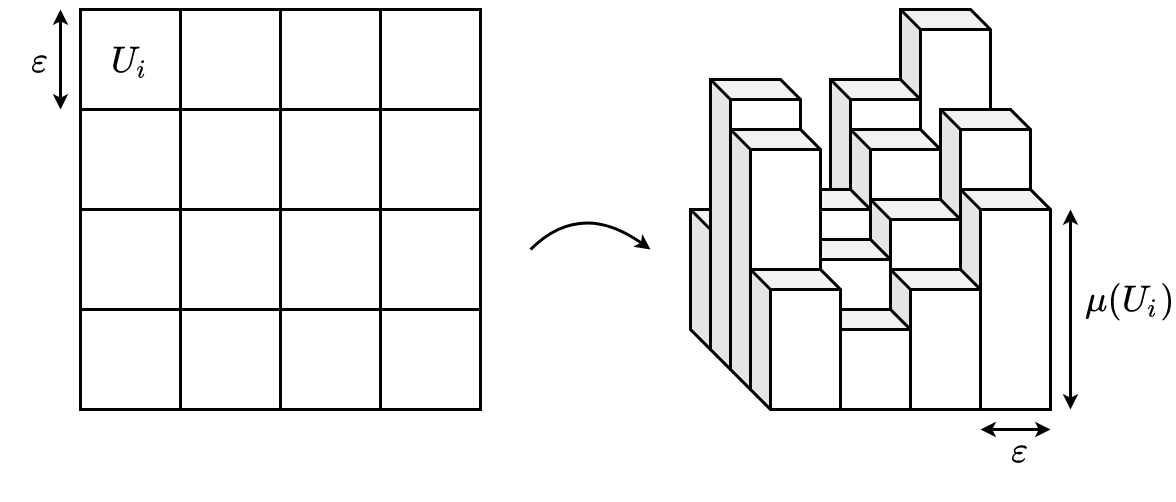

#### Special Values of the Rényi Dimension

##### $D(0)$: The Box-Counting Dimension (Again)

Consider the Renyi dimension for $q=0$,

$$D(0) = \frac{1}{1-0}\lim_{\epsilon \to 0} \frac{\log \left (\sup_{\mathcal{B}_\epsilon^C}\sum_{i=1}^{|C|} \mu(B(c_i, \epsilon))^0 \right )}{\log (1/\epsilon)} = \frac{\log \left (\sup_{\mathcal{B}_\epsilon^C} |C| \right )}{\log (1/\epsilon)} = \lim_{\epsilon \to 0} \frac{N(\epsilon)}{\log (1/\epsilon)}$$

where the last equality follows from the fact that $\mathcal{B}_\epsilon^C$ is a centered packing of $\textsf{supp}\{\mu\}$ so $\sup_{\mathcal{B}_\epsilon^C} |C|$ is the largest number of disjoint $\epsilon$-balls with centers in $\textsf{supp}\{\mu\}$. We see that $D(0)$ is simply the box-counting dimension of the support of $\mu$.

##### $D(1)$: The Information Dimension

##### $D(2)$: The Correlation Dimension

#### The Meaning of the Exponent $q$ in the Rényi Dimension

In [446]:
Renyi_Entropy_1 = lambda q, p1: -(1/(q-1)) * np.log(p1**q + (1-p1)**q)

Shannon_1 = lambda p1: -p1*np.log(p1) - (1-p1)*np.log(1-p1)

Max_Renyi_1 = lambda p1: np.array([np.log(2) for i in p1])

Min_Renyi_1 = lambda p1: np.array([-np.log(np.max([i, 1-i])) for i in p1])

In [579]:
qs = [-3, -2, -0.5, 0.5, 2, 3]
p1 = np.linspace(0, 1, 1000)

with np.errstate(divide='ignore', invalid='ignore'):
    Renyi_1D = [Max_Renyi_1(p1)] + [Shannon_1(p1)] + [Renyi_Entropy_1(q, p1) for q in qs] + [Min_Renyi_1(p1)]

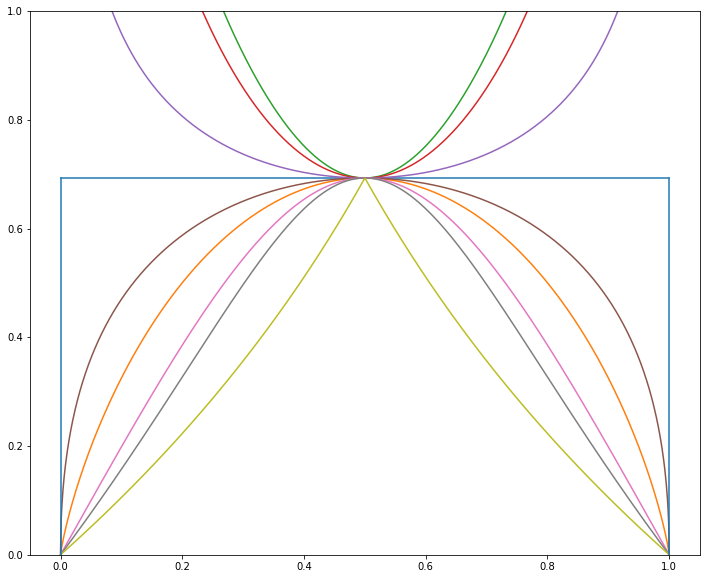

In [580]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

for i in range(len(Renyi_1D)):
    ax.plot(p1, Renyi_1D[i])
    ax.set_ylim((0, 1))
ax.axvline(x=0, ymin=0, ymax=np.log(2))
ax.axvline(x=1, ymin=0, ymax=np.log(2))

Thus we see that increasing values of $q$ give greater emphasis to larger probability values, that is, probabilities that are closer to uniform.

##### The Relationship Between Correlations and the Rényi Dimension

## Measures Commonly Found in Multifractal Analysis

## Characterizing Irregularity Across Scales: The Multifractal Spectrum

### The Hölder Exponent $\alpha$: A Local Measure of Roughness

The fundamental way to characterize irregularities in some object or process of interest is to look at each point $x$ in the set defining the object and see how the object scales in the region around that point. We will see that this local scaling behavior can be defined by in two alternative ways depending on the class of objects we are interested in. One definition is suited for measures defined on point processes, while the other is defined for functions (i.e. stochastic processes, time series).

For functions and stochastic processes, one examines the scaling behavior around individual points in the domain of the function by comparing the function evaluated at those points to a polynomial

For measures, one examines the scaling behavior around individual points in the support of the measure. Given a point $x \in \textsf{supp}\{\mu\}$, one assumes the hypothesis that the measure of an $\epsilon$-ball around $x$ scales with exponent $\alpha$:

$$\mu(B(x, \epsilon)) \propto \epsilon^{-\alpha}$$

$$\alpha_\mu(x) = \lim_{\epsilon \to 0} \frac{\log \left(\mu(B(x,\epsilon))\right)}{\log (1/\epsilon)}$$

In [799]:
Szm = 2**10
Mults = np.ones((10,Szm))

for lev in range(8, -1, -1):
    block_size = 2**lev
    mm = np.random.normal(size=int(Szm/block_size))
    for i in range(int(Szm/block_size)):
        Mults[9-lev, i*block_size:(i+1)*block_size] = mm[i]*Mults[9-lev-1, i*block_size]

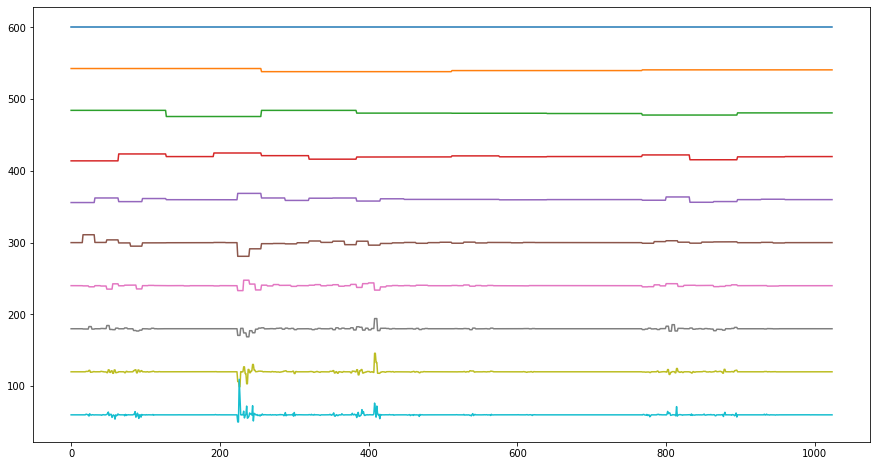

In [823]:
plt.figure(figsize=(15,8))
for i in range(10):
    plt.plot(Mults[i,:]+(10-i)*60)

In [770]:
def MakeBlock(n,m,p):
    M = np.zeros((n,m))
    II = int(n/3)
    JJ = int(m/3)
    M[0:II,0:JJ] = p[0]
    M[0:II,JJ:2*JJ] = p[1]
    M[0:II,2*JJ:] = p[2]
    M[II:2*II,0:JJ] = p[3]
    M[II:2*II,JJ:2*JJ] = p[4]
    M[II:2*II,2*JJ:] = p[5]
    M[2*II:,0:JJ] = p[6]
    M[2*II:,JJ:2*JJ] = p[7]
    M[2*II:,2*JJ:] = p[8]
    return M
    
    
ps = [1/10, 2/35, 6/35, 3/35, 2/7, 3/70, 1/14, 3/70, 1/7]
Sz = 3**5
Meas = np.zeros((Sz, Sz))
Probs = np.ones((Sz, Sz))
Casc = np.ones((Sz, Sz))

for lev in range(5, 0, -1):
    block_size = 3**lev
    CC = MakeBlock(block_size, block_size, ps)
    for j in range(int(Sz/block_size)):
        for i in range(int(Sz/block_size)):
            pp = ps[np.random.randint(low=0,high=len(ps))]
            Meas[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size] = pp
            Probs[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size] *= pp
            Casc[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size] += CC

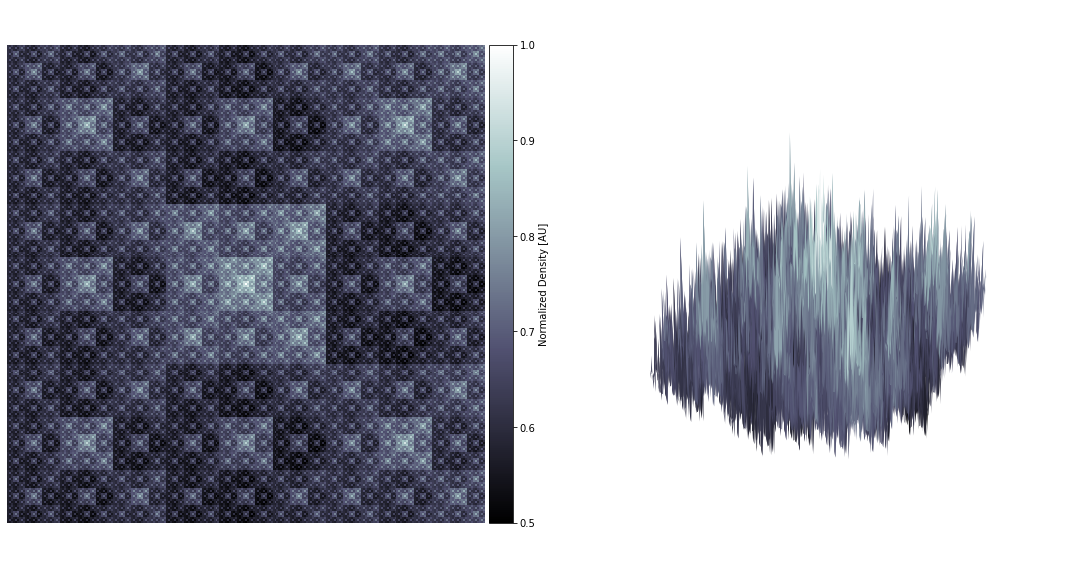

In [837]:
xx = np.linspace(0,1,3**5)
yy = np.linspace(0,1,3**5)
X,Y = np.meshgrid(xx, yy)

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.set_axis_off()
im = ax1.imshow((Casc/np.max(Casc)), cmap='bone')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
_ = plt.colorbar(im, cax=cax, label='Normalized Density [AU]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_axis_off()
ax2.plot_surface(X, Y, Casc/np.max(Casc), cmap='bone')

fig.tight_layout()

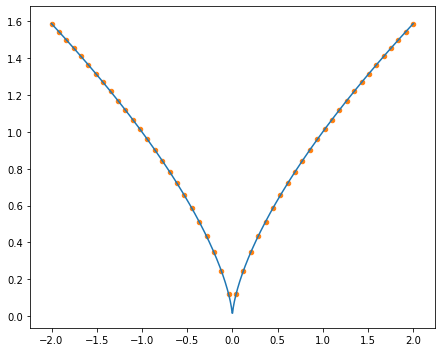

In [440]:
f = lambda x: np.cbrt(np.abs(x))**2
fp = lambda x: np.abs(f(x) - f(0))
xvec = np.linspace(-2,2,1000)
xpvec = np.linspace(-2,2,50)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.plot(xvec, f(xvec))
ax1.scatter(xpvec, fp(xpvec), s=20, c='C1')
fig.tight_layout()

### The Fractal Manifold and the Singularity Spectrum $f(\alpha)$: A Global Measure of Inhomogeneity

This leads again to a different definition of the fractal manifold of the measure $\mu$:

$$E_\mu(\alpha) = \left \{ x \in \textsf{supp}\{ \mu \} \mid \lim_{\epsilon \to 0} \frac{\log \left(\mu(B(x,\epsilon))\right)}{\log (1/\epsilon)} = \alpha \right \}$$

## Multifractal Formalisms: Folk Theorems From Physics

For a complete and rigorous presentation 

### The Legendre Multifractal Formalism

#### A Primer on the Legendre Transform

#### The Box Legendre Spectrum

### The Large Deviations Multifractal Formalism

### Direct Calculation of The Singularity Spectrum from the Partition Function

Thanks to a theorem proven by Eggleston (1949), Chhabra and Jensen (1989) showed that one could directly compute the singularity spectrum from the partition function, avoiding the use of the Legendre transform of the mass exponent. However, it must be stressed that the theorem does not hold generically for all possible measures we might be interested in, which limits its applicability.

Although Eggleston originally proved the theorem, it is stated more clearly and in the form used by Chhabra and Jensen in Billingsley (1965). We state the theorem here but do not prove it:

**Theorem [Eggleston, 1949]** Consider a number $\omega \in \mathbb{R}^+$. Fix a base $r$ so that $\omega$ may be represented as an infinite decimal, $\omega = a_0.a_1 a_2...$ with $a_k \in \{0,...,r-1\}$. The number $\omega$ has the decimal expansion

$$\omega = \sum_{k=0}^\infty \frac{a_k}{r^k}$$

Let $N_j(\omega, n)$ be the number of occurences of the digit $j \in \{0,...,r-1\}$ in the first $n$ digits of $\omega$, 

$$ N_j(\omega, n) = \#(j \in \{a_0,...,a_n\})$$

If $\{p_j\}_{j=1}^{r-1}$ is a set of probabilities such that $\sum_{j=1}^{r-1} p_j = 1$, then we define the set $M(p_0,...,p_{r-1})$ as

$$M(p_0,...,p_{r-1}) = \left \{\omega \mid \lim_{n\to \infty} \frac{N_j(\omega, n)}{n} = p_j \right \}$$

Then the Hausdorff dimension of $M(p_0,...,p_{r-1})$ is

$$\textsf{dim}_H \{ M(p_0,...,p_{r-1})\} = -\frac{1}{\log(r)} \sum_{j=0}^{r-1} p_j \log(p_j) $$

In [585]:
p = np.random.rand(10)
p = p/np.max(p)

<StemContainer object of 3 artists>

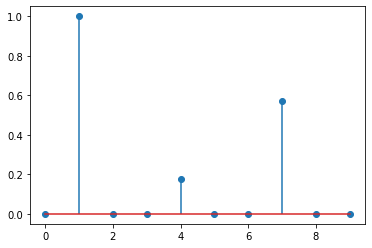

In [588]:
plt.stem(p*, use_line_collection=True)

### Wavelet Multifractal Formalisms

#### A Primer on Wavelets

#### Wavelet Transform Modulus Maxima Formalism

#### Wavelet Leaders Formalism